# "Convolutional Model Building Blocks"
> "An attempt at implementing a CNN to from scratch using NumPy to better understand its working."
- toc: true
- branch: master
- badges: true
- comments: false
- categories: [dl]
- image: images/backprop.png
- hide: false
- search_exclude: false

> Note: Gist hosted [here](https://gist.github.com/PseudoCodeNerd/ae94cc895a1c9302853306abdf99a49b).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline




### TODO:
- Convolution Functions
     - Zero padding
     - Convolve window
     - Forward convolution
     - Backward Convolution
- Pooling Function
     - Forward pool
     - Mask creation
     - Value distribution
     - Backward Pool
---

<center>Basic structure of CNN</center>

![image.png](img/model_cnn.png)


### Zero Padding
To add zeros around the image matrix to prevent loss of features due to scaling down after one step of a convolution.
*Same Convolution*: padding such that h-w of original image preserved after one layer.

In [2]:
def zero_pad(X, p):
    """
    params
    X: (n, nH, nW, nC) dims array representing a batch of images
    p: int, amount of padding around each image
    """
    pad_width = ((0, 0), (p, p), (p, p), (0, 0))
    X_p = np.pad(X, pad_width, mode='constant', constant_values=(0, 0))
    return X_p

An example of padding some sample data and demonstrating.

X.shape =
 (1, 3, 3, 2)
x_p.shape =
 (1, 7, 7, 2)


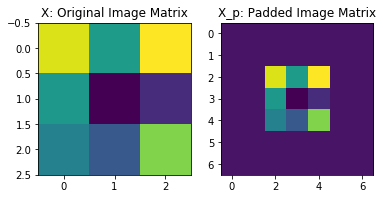

In [4]:
np.random.seed(0)
x = np.random.randn(1, 3, 3, 2)
x_p = zero_pad(x, 2)
print ("X.shape =\n", x.shape)
print ("x_p.shape =\n", x_p.shape)
fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('X: Original Image Matrix')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('X_p: Padded Image Matrix')
axarr[1].imshow(x_p[0,:,:,0])

### Convolution

1. `conv_one_part()`
    -   TODO:  Take input volume (matrix by no. of channels) and **convolve** filter against it to output new volume with features (hopefully) identified.

`conv_one_part()` will apply convolution to a part of the given image matrix (X) of dimensions filter_h x filter_w, taking steps of value *stride* after each iteration of the function.
To be implemented in the next function.

In [5]:
def conv_one_part(a_slice, W, b):
    """
    params
    m_slice: slice of input matrix; dims --> (f_h, f_w, nC_prev)
    W: Weight params contained in a window; dims --> (f_h, f_w, nC_prev)
    b: Bias params contained in a window; dims --> (1, 1, 1) : scalar
    """
    Z = float(np.add(np.sum(np.multiply(a_slice, W)), b))
    return Z

2. `forward_conv()`
    - TODO: Take multiple filters and convolve all of them on the input. Stack 2D Matrix outputs to produce output volume giving result of a single forward pass of convolution.

In [10]:
def forward_conv(A_prev, W, b, hparams):
    """
    params
    A_prev: previous layer activation; dims --> (n, nH, nW, nC_prev)
    W: Weight params contained in a window; dims --> (f_h, f_w, nC_prev, nC)
    b: Bias params contained in a window; dims --> (1, 1, 1, nC) : scalar
    hparams: dict containing values for stride and padding
    
    return
    Z: conv step output; dims --> (n, nH, nW, nC)
    cache: for calculating derivatives in backward_conv()
    """
    # Init: Dimensions, hparams
    (n, nH_prev, nW_prev, nC_prev) = np.shape(A_prev)
    (f, f, nC_prev, nC) = np.shape(W)
    s = hparams['stride']
    pad = hparams['padding']
    nH = int((nH_prev-f+2*pad)/s)+1
    nW = int((nW_prev-f+2*pad)/s)+1
    Z = np.zeros((n, nH, nW, nC))
    
    # Applying padding to prev layer activation
    A_prev_p = zero_pad(A_prev, pad)
    
    # Loop (Vectorization >>>>>>> Loops) to apply convolution operation.
    for i in range(n):
        a_prev_p = A_prev_p[i, :, :, :]
        for h in range(nH):
            for w in range(nW):
                vert1_f, vert2_f = h*s, h*s+f
                hori1_f, hori2_f = w*s, w*s+f
                for c in range (nC):
                    # slice
                    a_slice = a_prev_p[vert1_f:vert2_f, hori1_f:hori2_f, :]
                    Z[i, h, w, c] = conv_one_part(a_slice, W[:, :, :, c], b[:, :, :, c])
    # for backward_conv()               
    cache = (A_prev, W, b, hparams)
#     assert(Z.shape == (n, nH, nW, nC))

    return (Z, cache)

#### Testing one iteration of `forward_conv()` on sample data.

In [8]:
np.random.seed(1)
A_prev = np.random.randn(10,8,8,4)
W = np.random.randn(3,3,4,8) # channels of A_prev and W has to be the same (here, 4)
b = np.random.randn(1,1,1,8)
hparams = {"padding" : 2, "stride": 2}

Z, cache_conv = forward_conv(A_prev, W, b, hparams)
print("Z's mean =\n", np.mean(Z))
print("Z[3,2,1] =\n", Z[3,2,1])
print("cache_conv[0][1][2][3] =", cache_conv[0][1][2][3])

Z's mean =
 -0.1282614539128993
Z[3,2,1] =
 [ 4.98925312 -0.12934609  6.77487928 -6.44934224  1.80531313  8.75470928
 -2.85387942 -2.65858316]
cache_conv[0][1][2][3] = [-0.9970198  -0.10679399  1.45142926 -0.61803685]


### Pooling
Pooling operation after convolution to keep strong features by taking the maximum / average value contained in a sub-matrix of dims of the filter. Pooling helps reduce computation, as well as helps make feature detectors more invariant to its position in the input. 
`forward_pool()` implments a forward pass of the pooling layer. By default, *maxpool*.

In [21]:
def forward_pool(A_prev, hparams, mode="maxpool"):
    """
    params
    A_prev: previous layer activation; dims --> (n, nH, nW, nC_prev)
    hparams: dict containing values for filter_size and padding
    mode: pooling to perform; default --> maxpool
    
    return
    A: pool step output; dims --> (n, nH, nW, nC)
    cache: for calculating derivatives in backward_pool()
    """
    # Init: Dimensions, hparams
    (n, nH_prev, nW_prev, nC_prev) = np.shape(A_prev)
    s = hparams['stride']
    fs = hparams['filt_size']
    nH = int((nH_prev-fs)/s)+1
    nW = int((nW_prev-fs)/s)+1
    nC = nC_prev
    A = np.zeros((n, nH, nW, nC))
    
    # Loop (Vectorization >>>>>>> Loops) to apply pooling operation.
    for i in range(n):
        for h in range(nH):
            for w in range(nW):
                for c in range(nC):
                    vert1_f, vert2_f = h*s, h*s+fs
                    hori1_f, hori2_f = w*s, w*s+fs
                    a_slice = A_prev[i, vert1_f:vert2_f, hori1_f:hori2_f, c]
                    if mode == 'maxpool': A[i, h, w, c] = np.max(a_slice)
                    elif mode == 'avrgpool': A[i, h, w, c] = np.mean(a_slice)
    # for backward_conv()               
    cache = (A_prev, hparams)
#     assert(A.shape == (n, nH, nW, nC))
    return (A, cache)

#### Testing one iteration of `forward_pool(mode='maxpool')` on sample data.

In [22]:
np.random.seed(1)
A_prev = np.random.randn(1, 5, 5, 3)
hparams = {"stride" : 2, "filt_size": 3}

print('A_prev.shape = ' + str(A_prev.shape))
print("A = \n", A_prev)
print()
A, cache = forward_pool(A_prev, hparams)
print("Pooling type : Max Pooling")
print("A.shape = " + str(A.shape))
print("A =\n", A)
print()
A, cache = forward_pool(A_prev, hparams, mode = "avrgpool")
print("Pooling type : Average Pooling")
print("A.shape = " + str(A.shape))
print("A =\n", A)

A_prev.shape = (1, 5, 5, 3)
A = 
 [[[[ 1.62434536 -0.61175641 -0.52817175]
   [-1.07296862  0.86540763 -2.3015387 ]
   [ 1.74481176 -0.7612069   0.3190391 ]
   [-0.24937038  1.46210794 -2.06014071]
   [-0.3224172  -0.38405435  1.13376944]]

  [[-1.09989127 -0.17242821 -0.87785842]
   [ 0.04221375  0.58281521 -1.10061918]
   [ 1.14472371  0.90159072  0.50249434]
   [ 0.90085595 -0.68372786 -0.12289023]
   [-0.93576943 -0.26788808  0.53035547]]

  [[-0.69166075 -0.39675353 -0.6871727 ]
   [-0.84520564 -0.67124613 -0.0126646 ]
   [-1.11731035  0.2344157   1.65980218]
   [ 0.74204416 -0.19183555 -0.88762896]
   [-0.74715829  1.6924546   0.05080775]]

  [[-0.63699565  0.19091548  2.10025514]
   [ 0.12015895  0.61720311  0.30017032]
   [-0.35224985 -1.1425182  -0.34934272]
   [-0.20889423  0.58662319  0.83898341]
   [ 0.93110208  0.28558733  0.88514116]]

  [[-0.75439794  1.25286816  0.51292982]
   [-0.29809284  0.48851815 -0.07557171]
   [ 1.13162939  1.51981682  2.18557541]
   [-1.39649634

## Convolution Layer - Backward Pass
*Note: $dZ_{hw}$ is a scalar corresponding to the gradient of the cost with respect to the output of the conv layer Z at the hth row and wth column (corresponding to the dot product taken at the ith stride left and jth stride down).*

Further, We need to compute :
1. $dA$ (w.r.t cost for a certain filter $W_{c}$)
     $$ dA += \sum _{h=0} ^{n_H} \sum_{w=0} ^{n_W} W_c \times dZ_{hw} \tag{1}$$
     
     - Notice, how everytime the same filter is multiplied by a different derivative of cost w.r.t output of conv layer Z ($dZ$)
2. $dW$ (derivative of one filter w.r.t to the loss)
    $$ dW_c  += \sum _{h=0} ^{n_H} \sum_{w=0} ^ {n_W} a_{slice} \times dZ_{hw}  \tag{2}$$
    - Where, $a_{slice}$ is the slice of original matrix used to generate activation $Z_{ij}$. This follows from the fact that the filter matrix can also learn (from backprop) optimal values.   
3. $db$ ( w.r.t to the cost of a certain filter $dW_{c}$)
    $$ db = \sum_h \sum_w dZ_{hw} \tag{3}$$
    
    - summing over all the gradients of the conv output (Z) with respect to the cost.
    
#### `backward_conv()` : To implement the backward propagation for a convolution function

In [23]:
def backward_conv(dZ, cache):
    """
    params
    dZ: gradient of cost w.r.t conv layer output (Z); dims --> (n, nH, nW, nC)
    cache: cache of values needed for backward_conv(); i.e. output of forward_conv()
    
    returns
    see above (markdown)
    """
    # Init: Dimensions, hparams
    (A_prev, W, b, hparams) = cache
    (n, nH_prev, nW_prev, nC_prev) = np.shape(A_prev)
    (f, f, nC_prev, nC) = np.shape(W)
    s = hparams['stride']
    pad = hparams['padding']
    (n, nH, nW, nC) = np.shape(dZ)
    
    dA_prev = np.zeros_like(A_prev)
    dW = np.zeros_like(W)
    db = np.zeros_like(b)
    
    A_prev_p = zero_pad(A_prev, pad)
    dA_prev_p  = zero_pad(dA_prev, pad)
    
    # Loop (Vectorization >>>>>>> Loops) for backward convolution step.
    for i in range(n):
        a_prev_p = A_prev_p[i, :, :, :]
        da_prev_p = dA_prev_p[i, :, :, :]
        for h in range(nH):
            for w in range(nW):
                for c in range(nC):
                    vert1_f, vert2_f = h*s, h*s+f
                    hori1_f, hori2_f = w*s, w*s+f
                    # slice
                    a_slice = a_prev_p[vert1_f:vert2_f, hori1_f:hori2_f, :]
                    # updating gradients
                    da_prev_p[vert1_f:vert2_f, hori1_f:hori2_f, :] += W[:, :, :, c] * dZ[i, h, w, c]
                    dW[:, :, :, c] += a_slice * dZ[i, h, w, c]
                    db[:, :, :, c] += dZ[i, h, w, c]
        dA_prev[i, :, :, :] = da_prev_p[pad:-pad, pad:-pad, :]
    
#     assert(dA_prev.shape == (m, nH_prev, nW_prev, nC_prev))
    return dA_prev, dW, db

#### Testing `backward_conv()` on sample data.

In [25]:
# We'll run conv_forward to initialize the 'Z' and 'cache_conv",
# which we'll use to test the conv_backward function
np.random.seed(1)
A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,6) # six filters
b = np.random.randn(1,1,1,6)
hparameters = {"padding" : 2, "stride": 2}
Z, cache_conv = forward_conv(A_prev, W, b, hparameters)
# Testing backward_conv()
dA, dW, db = backward_conv(Z, cache_conv)
print("dA_mean =", np.mean(dA))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))

dA_mean = -0.9683520023516613
dW_mean = -3.028451139022465
db_mean = 41.04575496729348


## Pooling Layer - Backward Pass
Although, pooling layer has no learnable parameters for backpropagation, we still need to go through the pooling layer to complete gradient computation for layers that come before pooling layer.

To compute backward pooling, we would need a function `mask_window()` to create a matrix which keeps track of where the maximum of the matrix is. 

$$ X = \begin{bmatrix}
1 && 2 \\
3 && 4
\end{bmatrix} \quad \rightarrow  \quad M =\begin{bmatrix}
0 && 0 \\
0 && 1
\end{bmatrix}$$

#### But, why do we keep track of the position of the max? 

It's because this is the input value that ultimately influenced the output, and therefore the cost. Backprop is computing gradients with respect to the cost, so anything that influences the ultimate cost should have a non-zero gradient. So, backprop will "propagate" the gradient back to this particular input value that had influenced the cost.

In [29]:
def max_mask(x):
    """
    params
    x: input matrix to be masked
    
    returns
    m_x: masked matrix, same dims as x, 1 / True at max elem position
    """
    m_x = (x == np.max(x))
    return m_x

In [30]:
np.random.seed(1)
x = np.random.randint(10, size=(3, 3))
print('x = ', x)
print('m_x = ', max_mask(x))

x =  [[5 8 9]
 [5 0 0]
 [1 7 6]]
m_z =  [[False False  True]
 [False False False]
 [False False False]]


We would also need a similar mask function for average pooling as well. 

In case of average pooling, every elem of the sliced (window) matrix has equal influence on the output *unlike* max pooling where maximum influence is by the largest element.

In [32]:
def avrg_mask(x, dims):
    """
    params
    x: input scalar to be masked
    dims: dims of array we want to distribute x to. 
    
    returns
    m_x: masked matrix, same dims as x with x distributed among it
    """
    (nH, nW) = dims
    avg  = x/(nH*nW)
    m_x = avg * np.ones((nH, nW))
    return m_x

In [39]:
print('Value to be Distributed: ', 25,'\nDistributed / Average Mask:\n', avrg_mask(25, (3, 3)))

Value to be Distributed:  25 
Distributed / Average Mask:
 [[2.77777778 2.77777778 2.77777778]
 [2.77777778 2.77777778 2.77777778]
 [2.77777778 2.77777778 2.77777778]]


Now with our helper functions in place, we can proceed towards writing our final function of the day `backward_pool()`.

In [44]:
def backward_pool(dA, cache, mode='maxpool'):
    """
    params
    dA: gradient of cost w.r.t output of pooling layer; dims --> like A
    cache: cache output from forward step of pooling layer; contains inputs and hparams
    moode: max/average pool
    
    returns
    dA_prev: gradient of cost w.r.t input of pooling layer; dims --> like A_prev
    """
    # Init; Dimensions and hparams
    (A_prev, hparams) = cache
    s = hparams['stride']
    fs = hparams['filt_size']
    (n, nH, nW, nC) = np.shape(dA)
    (n, nH_prev, nW_prev, nC_prev) = np.shape(A_prev)
    dA_prev = np.zeros_like(A_prev)
    
    # Loop (Vectorization >>>>>>> Loops) for backward pooling step.
    for i in range(n):
        a_prev = A_prev[i, :, :, :]
        for h in range(nH):
            for w in range(nW):
                for c in range(nC):
                    vert1_f, vert2_f = h*s, h*s+fs
                    hori1_f, hori2_f = w*s, w*s+fs
                    if mode=='maxpool':
                        a_prev_slice = a_prev[vert1_f:vert2_f, hori1_f:hori2_f, c]
                        # create mask from a_prev_slice
                        mask = max_mask(a_prev_slice)
                        dA_prev[i, vert1_f:vert2_f, hori1_f:hori2_f, c] += mask * dA[i, h, w, c]
                    elif mode=='avrgpool':
                        da = dA[i, h, w, c]
                        dims = (fs, fs)
                        dA_prev[i, vert1_f:vert2_f, hori1_f:hori2_f, c] += avrg_mask(da, dims)
                        
#     assert(dA_prev.shape == A_prev.shape)
    
    return dA_prev

#### Testing `backward_pool()` on sample data.

In [46]:
np.random.seed(1)
A_prev = np.random.randn(5, 5, 3, 2)
hparameters = {"stride" : 1, "filt_size": 2}
A, cache = forward_pool(A_prev, hparameters)
dA = np.random.randn(5, 4, 2, 2)

dA_prev = backward_pool(dA, cache, mode = "maxpool")
print("Pooling type : Max Pooling")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1])  
print()
dA_prev = backward_pool(dA, cache, mode = "avrgpool")
print("Pooling type : Average Pooling")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1])

Pooling type : Max Pooling
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.          0.        ]
 [ 5.05844394 -1.68282702]
 [ 0.          0.        ]]

Pooling type : Average Pooling
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.08485462  0.2787552 ]
 [ 1.26461098 -0.25749373]
 [ 1.17975636 -0.53624893]]


---

With this, we have completed all the basic building ~~blocks~~ functions required to build a Convolutional Model.

While coding this out, I was able to greatly increase my understanding about the mathematical working beneath both convolution and pooling operations. 

With deeplearning libraries such as PyTorch and Tensorflow making such things a breeze, (only 10 lines of pytorch code to do all things I've done in this notebook) it's not practical to define CNN models from scratch using numpy since tensors (numpy arrays + GPU support) are the go-to. Still, this endeavour turned out to be extremely knowledgable and *EPIC*.

### *kthnxbye*